# 1. High order pathology for the Stiffness matrix

For this chapter, we will need the [GeLaTo](https://github.com/pyccel/GeLaTo) library.

In this example, we show the dependency of the **stiffness** symbol with respect to the spline degree in 1d, we will also give some asymptotic expansion of the basic operators: **stiffness**, **mass** and **advection**.

In [1]:
# ... needed imports
from numpy import linspace, zeros, pi
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Math

from sympy import Symbol
from sympy import Lambda

from gelato.glt import glt_symbol
from gelato.glt import glt_lambdify
from gelato.calculus   import Dot, Grad, dx

from spl.fem.splines import SplineSpace

We define the weak form, as:

In [2]:
x = Symbol('x')

u = Symbol('u')
v = Symbol('v')

a_s = Lambda((x,v,u), Dot(Grad(u), Grad(v)))

In [3]:
V = SplineSpace(2, grid=linspace(0., 1., 32+1))

In [4]:
from IPython.display import Math
from gelato.printing.latex import glt_latex

symbol = glt_symbol(a_s, space=V, evaluate=True)
Math(glt_latex(symbol))

<IPython.core.display.Math object>

In [5]:
from gelato.fem.utils    import compile_symbol
symbol_s = compile_symbol('symbol_1', a_s, V, backend='fortran')

In [6]:
# ... make the symbol a numeric function, that can be evaluated
f = glt_lambdify(symbol)

nx = 100
x = linspace(  0, 1, nx)
t = linspace(-pi,pi, nx)
w = f(x,t)
# ...

# ... example of symbol evaluation
e = zeros(nx)
symbol_s(x, t, e)
# ...


In [7]:
from numpy import allclose

allclose(e,w)

True

The following function allows to plot the eigenvalues for a given *grid* and different spline **degrees**:

In [8]:
def plot_symbols(expr, degrees=[2, 3], ne=64):
    
    colors = ["r", "b", "g", "y", "m", "k", "c"]

    for i,p in enumerate(degrees):
        # ...  create a finite element space
        V = SplineSpace(p, grid=linspace(0., 1., ne+1))
        # ...

        # ... compute the GLT symbol
        symbol = glt_symbol(expr, space=V, evaluate=True)
        # ...

        # ... make the symbol a numeric function, that can be evaluated
        f = glt_lambdify(symbol)

        nx = 100
        x1 = linspace(  0, 1, nx)
        t1 = linspace(-pi,pi, nx)
        w = f(x1,t1)
        # ...
        
        plt.plot(t1, w.real, "-"+colors[i], label="$p=" + str(p) + "$")
        plt.legend(loc=9);

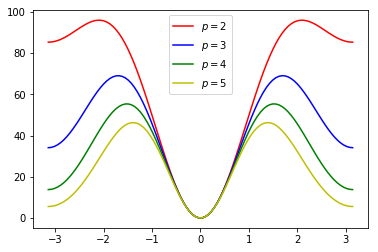

In [9]:
plot_symbols(a_s, degrees=[2, 3, 4, 5])

As expected, we notice the convergence to 0 at $| \theta | = \pi$.

We consider now the weak formulation related to the **mass** matrix:

In [11]:
x = Symbol('x')

u = Symbol('u')
v = Symbol('v')

# weak form for the mass matrix
a_m = Lambda((x,v,u), u * v)

We will use the following function to plot the division of the symbol of the **stiffness** by the symbol of the **mass**  of degree $p-1$

In [6]:
def plot_symbols(expr_s, expr_m, degrees=[2, 3], ne=64):
    
    colors = ["r", "b", "g", "y", "m", "k", "c"]

    for i,p in enumerate(degrees):
        # ...  create a finite element space
        V = SplineSpace(p, grid=linspace(0., 1., ne+1))
        W = SplineSpace(p-1, grid=linspace(0., 1., ne+1))
        # ...

        # ... compute the GLT symbol
        symbol_s = glt_symbol(expr_s, space=V, evaluate=True)
        symbol_m = glt_symbol(expr_m, space=W, evaluate=True)
        # ...

        # ... make the symbol a numeric function, that can be evaluated
        f_s = glt_lambdify(symbol_s)
        f_m = glt_lambdify(symbol_m)

        nx = 100
        x = linspace(  0, 1, nx)
        t = linspace(-pi,pi, nx)
        w = f_s(x,t) / f_m(x,t)
        # ...
        
        plt.plot(t, w.real, "-"+colors[i], label="$p=" + str(p) + "$")
        plt.legend(loc=9);

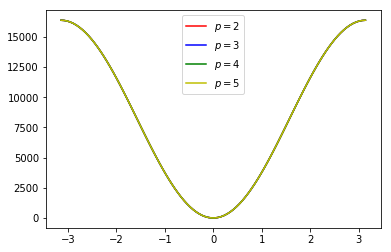

In [7]:
plot_symbols(a_s, a_m, degrees=[2, 3, 4, 5])

We see now that the *new symbol* is not sensitive to the *B-Spline* degree.

In fact, this symbol corresponds to the $S M^{-1}$ (and $M^{-1} S$), if we denote by $S$ and $M$ the *stiffness* and *mass* matrices respectively.

## Symbolic expression and asymptotic expansion 

In this section, we give the asymptotic expansion of the symbol associated to the **mass**, **stiffness** and **advection** matrices.

We start by defining our weak formulations:

In [12]:
x = Symbol('x')

u = Symbol('u')
v = Symbol('v')

a_m = Lambda((x,v,u), u * v)
a_s = Lambda((x,v,u), Dot(Grad(u), Grad(v)))
a_a = Lambda((x,v,u), dx(v) * u)

In [13]:
# ...
p  = 3
ne = 16
# ...

# ...  create a finite element space
V = SplineSpace(p, grid=linspace(0., 1., ne+1))
# ...

# ... compute the GLT symbol
symbol_m = glt_symbol(a_m, space=V, evaluate=True)
symbol_s = glt_symbol(a_s, space=V, evaluate=True)
symbol_a = glt_symbol(a_a, space=V, evaluate=True)
# ...

We can now evaluate, symbolicaly, the symbols at the sampling points, using the following function, and print them using *Latex*:

In [10]:
from gelato.printing.latex import glt_latex
from IPython.display import Math

t1 = Symbol("t1")

# ...
def to_latex(expr):    
    m = Symbol("m")
    N = Symbol("N")
    pi = Symbol("pi")
    return glt_latex(expr.subs({t1: 2 * pi * m / N}))
# ...

---
**Note**:
since **expr** is a sympy **Lambda** expression, we need to use its *expr* member

---

In [11]:
# symbol of the mass matrix
Math(to_latex(symbol_m.expr))

<IPython.core.display.Math object>

In [12]:
# symbol of the stiffness matrix
Math(to_latex(symbol_s.expr))

<IPython.core.display.Math object>

In [13]:
# symbol of the advection matrix
Math(to_latex(symbol_a.expr))

<IPython.core.display.Math object>

We now give the asymptotic expansion of the GLT symbol arount $0$, up to the order $8$:

In [14]:
# asymptotic expansion of the mass symbol
Math(to_latex(symbol_m.expr.series(t1,0,8)))

<IPython.core.display.Math object>

In [15]:
# asymptotic expansion of the stiffness symbol
Math(to_latex(symbol_s.expr.series(t1,0,8)))

<IPython.core.display.Math object>

In [16]:
# asymptotic expansion of the advection symbol
Math(to_latex(symbol_a.expr.series(t1,0,8)))

<IPython.core.display.Math object>

In [27]:
fs = glt_lambdify(symbol_s)
fm = glt_lambdify(symbol_m)
fa = glt_lambdify(symbol_a)

nx = 100
x1 = linspace(  0, 1, nx)
t1 = linspace(-pi,pi, nx)

s1 = fs(x1,t1)
m1 = fm(x1,t1)
a1 = fa(x1,t1)

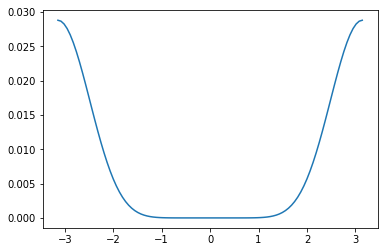

In [28]:
w = a1**2 + m1 * s1
plt.plot(t1, w.real);

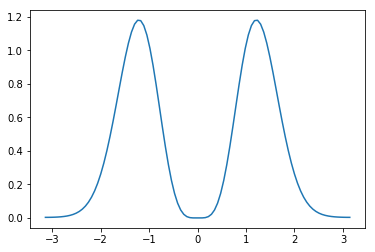

In [34]:
s2 = s1
m2 = m1
a2 = a1

w = (m1*s2 + m2*s1)**2 + 4*(a1**2*m2**2 + a2**2*m1**2)

plt.plot(t1, w.real);





In [43]:
# ...
p1  = 3 ; p2 = 3
ne1 = 64 ; ne2 = 64
# ...

# ...  create a finite element space
V1 = SplineSpace(p1, grid=linspace(0., 1., ne1+1))
V2 = SplineSpace(p2, grid=linspace(0., 1., ne2+1))
# ...

# ... compute the GLT symbol
symbol_m1 = glt_symbol(a_m, space=V1, evaluate=True)
symbol_s1 = glt_symbol(a_s, space=V1, evaluate=True)
symbol_a1 = glt_symbol(a_a, space=V1, evaluate=True)

symbol_m2 = glt_symbol(a_m, space=V2, evaluate=True)
symbol_s2 = glt_symbol(a_s, space=V2, evaluate=True)
symbol_a2 = glt_symbol(a_a, space=V2, evaluate=True)
# ...

# ...
fs1 = glt_lambdify(symbol_s1)
fm1 = glt_lambdify(symbol_m1)
fa1 = glt_lambdify(symbol_a1)

fs2 = glt_lambdify(symbol_s2)
fm2 = glt_lambdify(symbol_m2)
fa2 = glt_lambdify(symbol_a2)
# ...

x1 = x2 = linspace(  0, 1, 100)
t1 = t2 = linspace(-pi,pi, 100)

# ...
s1 = fs1(x1,t1)
m1 = fm1(x1,t1)
a1 = fa1(x1,t1)

s2 = fs2(x2,t2)
m2 = fm2(x2,t2)
a2 = fa2(x2,t2)
# ...

2.086594002048185e-06


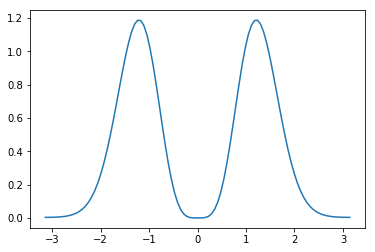

In [44]:
w = (m1*s2 + m2*s1)**2 + 4*(a1**2*m2**2 + a2**2*m1**2)
print(min(w.real))
plt.plot(t1, w.real);

In [14]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()